In [39]:
import json
import pandas as pd
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from scipy.stats import skellam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
import statsmodels.api as sm

In [40]:
def parse_2022():
    filename = './data/archive/2022.worldcup.quolification.output.jl'
    with open(filename) as f:
        data = pd.read_json(f.read(), lines=True)
    return data
data_2022 = parse_2022()
data_2022.rename(columns = {'team0':'home_team', 'team1':'away_team', 'score0': 'home_score', 'score1': 'away_score'}, inplace = True)
# area_and_stage = data_2022['area'].str.split(',', expand=True)
print(data_2022)

def parse_2002_to_2018():
    filename = './data/archive/2002-2018.worldcup.quolification.output.jl'
    with open(filename) as f:
        data = pd.read_json(f.read(), lines=True)
    return data

data_before = parse_2002_to_2018()
data_before.rename(columns = {'team0':'home_team', 'team1':'away_team', 'score0': 'home_score', 'score1': 'away_score'}, inplace = True)
print(data_before)


     year               area                  date   home_team    away_team  \
0    2022  UEFA, Group Stage    November 16, 2021    Gibraltar       Latvia   
1    2022     AFC, Round Two    September 5, 2019     Thailand      Vietnam   
2    2022   CAF, First Round   September 10, 2019     Eswatini     Djibouti   
3    2022  UEFA, Group Stage       March 27, 2021   Montenegro    Gibraltar   
4    2022           CONMEBOL     October 10, 2021    Venezuela      Ecuador   
..    ...                ...                   ...         ...          ...   
719  2022  UEFA, Group Stage    November 16, 2021      Finland       France   
720  2022  UEFA, Group Stage    September 4, 2021     Slovakia      Croatia   
721  2022     AFC, Round Two     October 10, 2019      IR Iran     Cambodia   
722  2022  UEFA, Group Stage    September 5, 2021      Albania      Hungary   
723  2022   AFC, Round Three     October 12, 2021      IR Iran  South Korea   

     home_score  away_score                   place

In [41]:
def parse_eufa(file_path="data/data.txt"):
    data = list()
    with open(file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 3
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split('\t')
            data.append(fields)

    return data


def parse_arc_data(result_file_path="data/archive/results.csv", shootout_file_path="data/archive/shootouts.csv"):
    data = list()

    with open(result_file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 39701
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split(',')

            # Add winner
            if fields[3] > fields[4]:
                fields.append(fields[1])
            elif fields[3] < fields[4]:
                fields.append(fields[2])
            else:
                fields.append("None")

            data.append(fields)

    with open(shootout_file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 403
        for line in islice(f, skip_start_line, None):
            date, ctry1, ctry2, winner = line.strip().split(',')

            for i in range(0, len(data)):
                if data[i][-1] == "None" and date == data[i][0]:
                    if (ctry1 == data[i][1] and ctry2 == data[i][2]) or (ctry1 == data[i][2] and ctry2 == data[i][1]):
                            data[i][-1] = winner
                    else:
                        continue

    return data


In [42]:
eufa_record = parse_eufa()
# print(eufa_record[0])

eufa_record_field_name = ['Date', 'Location', 'Country1', 'Country2', 'Score', 'Winner']
eufa_df = pd.DataFrame(eufa_record, columns =eufa_record_field_name)
print(eufa_df)

          Date     Location         Country1         Country2    Score  \
0   06/11/2021        Italy           Turkey            Italy      0:3   
1   06/12/2021   Azerbaijan            Wales      Switzerland      1:1   
2   06/12/2021      Denmark          Denmark          Finland      0:1   
3   06/12/2021       Russia          Belgium           Russia      3:0   
4   06/13/2021      England          England          Croatia      1:0   
5   06/13/2021      Romania          Austria  North Macedonia      3:1   
6   06/13/2021  Netherlands      Netherlands          Ukraine      3:2   
7   06/14/2021     Scotland         Scotland          Czechia      0:2   
8   06/14/2021       Russia           Poland         Slovakia      1:2   
9   06/14/2021        Spain            Spain           Sweden      0:0   
10  06/15/2021      Hungary          Hungary         Portugal      0:3   
11  06/15/2021      Germany           France          Germany      1:0   
12  06/16/2021       Russia          F

In [43]:
acr_record = parse_arc_data()
# print(acr_record[0])
# for record in acr_record:
#     if len(record) != 10:
#         print(record)

acr_record_field_name = ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country', 'neutral', 'winner']

acr_df = pd.DataFrame(acr_record, columns =acr_record_field_name)
acr_df['home_score'] = acr_df['home_score'].astype(int)
acr_df['away_score'] = acr_df['away_score'].astype(int)
print(acr_df)

            date        home_team             away_team  home_score  \
0     2018-01-02             Iraq  United Arab Emirates           0   
1     2018-01-02             Oman               Bahrain           1   
2     2018-01-05             Oman  United Arab Emirates           0   
3     2018-01-07          Estonia                Sweden           1   
4     2018-01-11          Denmark                Sweden           0   
...          ...              ...                   ...         ...   
3716  2022-03-30           Mexico           El Salvador           2   
3717  2022-03-30       Costa Rica         United States           2   
3718  2022-03-30           Panama                Canada           1   
3719  2022-03-30          Jamaica              Honduras           2   
3720  2022-03-30  Solomon Islands           New Zealand           0   

      away_score                    tournament         city  \
0              0                      Gulf Cup  Kuwait City   
1              0     

In [44]:
score_upperbound = 10
print(acr_df[acr_df['home_score'] > score_upperbound])
print(acr_df[acr_df['away_score'] > score_upperbound])

            date            home_team                 away_team  home_score  \
523   2018-09-08                 Cuba  Turks and Caicos Islands          11   
557   2018-09-10                Haiti              Sint Maarten          13   
641   2018-10-12              Bermuda              Sint Maarten          12   
1426  2019-07-15      Solomon Islands            American Samoa          13   
1433  2019-07-18        New Caledonia                    Tuvalu          11   
1712  2019-10-10                 Iran                  Cambodia          14   
1862  2019-11-10  Trinidad and Tobago                  Anguilla          15   
2532  2021-03-30                Japan                  Mongolia          14   
2652  2021-06-05               Panama                  Anguilla          13   

      away_score                             tournament            city  \
523            0  CONCACAF Nations League qualification          Havana   
557            0  CONCACAF Nations League qualification  Po

In [45]:
score_upperbound = 20
# print(acr_df[acr_df['home_score'].astype(int) > score_upperbound])

acr_df = acr_df.drop(acr_df[acr_df['home_score'] > score_upperbound].index)
acr_df = acr_df.drop(acr_df[acr_df['away_score'] > score_upperbound].index)
acr_df.describe()

,home_score,away_score
count,3721.000000,3721.000000
mean,1.613276,1.085461
std,1.704083,1.334088
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,2.000000,2.000000
max,15.000000,14.000000


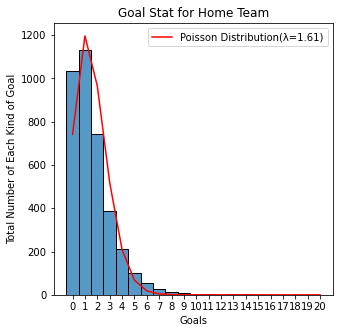

In [46]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = list(acr_df['home_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound + 1, 1))
plt.title('Goal Stat for Home Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_home = acr_df['home_score'].mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_home)*acr_df.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_home), color="red")

plt.legend()
plt.show()

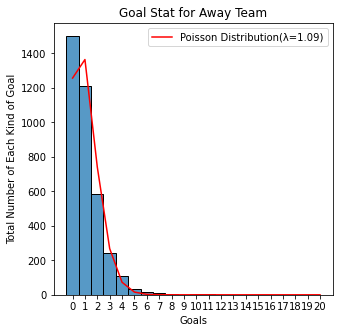

In [47]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = list(acr_df['away_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.title('Goal Stat for Away Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_away = acr_df['away_score'].mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_away)*acr_df.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_away), color="red")

plt.legend()
plt.show()

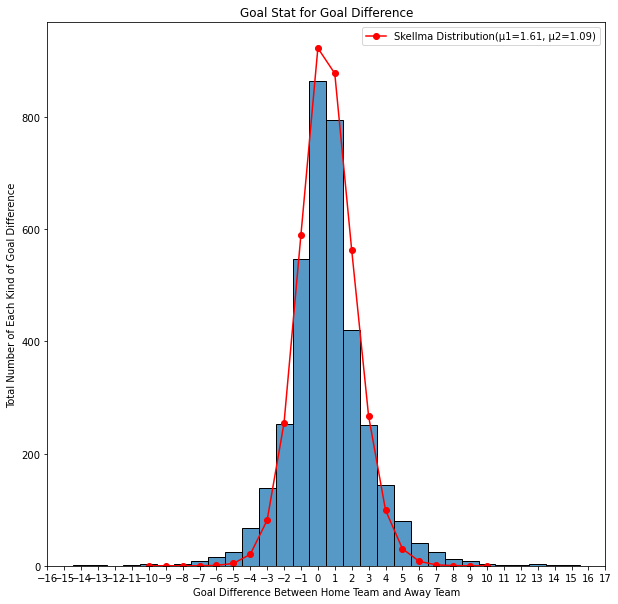

In [48]:
plt.figure(figsize=(10, 10))

x = list(range(score_upperbound * -1, score_upperbound + 1, 1))
y = list(acr_df['home_score'] - acr_df['away_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(score_upperbound * -1, score_upperbound + 1, 1))
plt.title('Goal Stat for Goal Difference')
plt.ylabel('Total Number of Each Kind of Goal Difference')
plt.xlabel('Goal Difference Between Home Team and Away Team')

plt.plot(np.arange(score_upperbound/2 * -1, score_upperbound/2 + 1), skellam.pmf(np.arange(score_upperbound/2 * -1, score_upperbound/2 + 1, 1), lambda_home, lambda_away)*acr_df.shape[0], '-o', label="Skellma Distribution(μ1={:.2f}, μ2={:.2f})".format(lambda_home, lambda_away), color="red")

plt.legend()
plt.show()

In [49]:
df = pd.read_csv('data/archive/results.csv')
grouped = df.groupby('tournament')
world_cup_df = grouped.get_group('FIFA World Cup')
number_of_goals = world_cup_df.home_score + world_cup_df.away_score
number_of_goals = number_of_goals[number_of_goals <= 10]
number_of_goals

1314     3
1315     5
1316     3
1317     4
1318     1
        ..
40129    4
40130    1
40131    3
40132    2
40133    6
Length: 896, dtype: int64

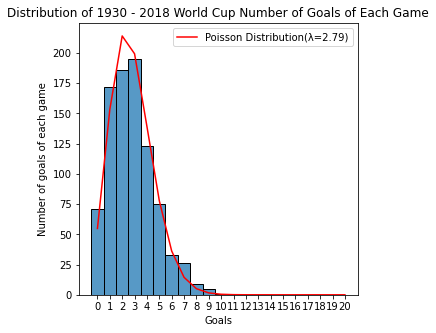

In [50]:
plt.figure(figsize=(5, 5))
score_upperbound = 20
x = list(range(0, score_upperbound + 1, 1))

sns.histplot(data=number_of_goals, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound + 1, 1))
plt.title('Distribution of 1930 - 2018 World Cup Number of Goals of Each Game')
plt.ylabel('Number of goals of each game')
plt.xlabel('Goals')

lambda_world_cup_number_of_goals = number_of_goals.mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_world_cup_number_of_goals)*number_of_goals.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_world_cup_number_of_goals), color="red")

plt.legend()
plt.show()

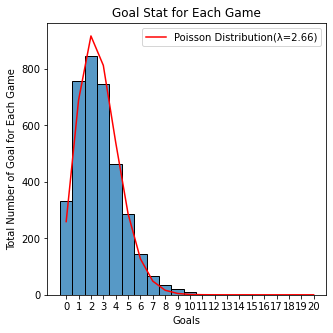

In [51]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound + 1, 1))
y = acr_df.home_score + acr_df.away_score
y = y[y<11]

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.title('Goal Stat for Each Game')
plt.ylabel('Total Number of Goal for Each Game')
plt.xlabel('Goals')

lambda_total = y.mean()
plt.plot(np.arange(score_upperbound + 1), poisson.pmf(np.arange(0, score_upperbound + 1, 1), lambda_total)*y.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_total), color="red")

plt.legend()
plt.show()

In [57]:
def parse_worldcup_host(file_path="data/worldcupdata.txt"):
    data = list()
    with open(file_path, mode='r', encoding='utf-8') as f:
        skip_start_line = 3
        for line in islice(f, skip_start_line, None):
            fields = line.strip().split('\t')
            data.append(fields)

    return data

In [58]:
acr_record_worldcup_host = parse_worldcup_host()


acr_record_field_name = ['date', 'home_team', 'away_team', 'home_score', 'away_score', 'tournament', 'city', 'country', 'neutral', 'winner']

acr_df_worldcup_host = pd.DataFrame(acr_record_worldcup_host, columns =acr_record_field_name)
acr_df_worldcup_host['home_score'] = acr_df_worldcup_host['home_score'].astype(int)
acr_df_worldcup_host['away_score'] = acr_df_worldcup_host['away_score'].astype(int)
print(acr_df_worldcup_host)

          date home_team      away_team  home_score  away_score  \
0    1930/7/27   Uruguay     Yugoslavia           6           1   
1    1930/7/30   Uruguay      Argentina           4           2   
2    1934/5/27     Italy  United States           7           1   
3    1934/5/31     Italy          Spain           1           1   
4     1934/6/1     Italy          Spain           1           0   
..         ...       ...            ...         ...         ...   
111  2018/6/14    Russia   Saudi Arabia           5           0   
112  2018/6/19    Russia          Egypt           3           1   
113  2018/6/25    Russia        Uruguay           0           3   
114   2018/7/1    Russia          Spain           1           1   
115   2018/7/7    Russia        Croatia           2           2   

         tournament              city  country neutral    winner  
0    FIFA World Cup        Montevideo  Uruguay   FALSE      Host  
1    FIFA World Cup        Montevideo  Uruguay   FALSE      H

In [59]:
score_upperbound_worldcup_host = 10
print(acr_df_worldcup_host[acr_df_worldcup_host['home_score'] < score_upperbound_worldcup_host])
print(acr_df_worldcup_host[acr_df_worldcup_host['away_score'] < score_upperbound_worldcup_host])

          date home_team      away_team  home_score  away_score  \
0    1930/7/27   Uruguay     Yugoslavia           6           1   
1    1930/7/30   Uruguay      Argentina           4           2   
2    1934/5/27     Italy  United States           7           1   
3    1934/5/31     Italy          Spain           1           1   
4     1934/6/1     Italy          Spain           1           0   
..         ...       ...            ...         ...         ...   
111  2018/6/14    Russia   Saudi Arabia           5           0   
112  2018/6/19    Russia          Egypt           3           1   
113  2018/6/25    Russia        Uruguay           0           3   
114   2018/7/1    Russia          Spain           1           1   
115   2018/7/7    Russia        Croatia           2           2   

         tournament              city  country neutral    winner  
0    FIFA World Cup        Montevideo  Uruguay   FALSE      Host  
1    FIFA World Cup        Montevideo  Uruguay   FALSE      H

In [60]:
acr_df_worldcup_host.describe()

,home_score,away_score
count,116.000000,116.000000
mean,1.862069,0.974138
std,1.559802,1.268078
min,0.000000,0.000000
25%,1.000000,0.000000
50%,2.000000,1.000000
75%,2.000000,1.000000
max,7.000000,7.000000


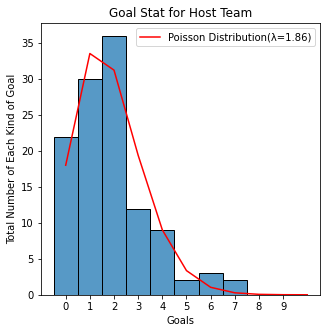

In [68]:
plt.figure(figsize=(5, 5))

x = list(range(0, score_upperbound_worldcup_host, 1))
y = list(acr_df_worldcup_host['home_score'])

sns.histplot(data=y, discrete=True)
plt.xticks(x)
plt.xticks(np.arange(0, score_upperbound_worldcup_host, 1))
plt.title('Goal Stat for Host Team')
plt.ylabel('Total Number of Each Kind of Goal')
plt.xlabel('Goals')

lambda_home = acr_df_worldcup_host['home_score'].mean()
plt.plot(np.arange(score_upperbound_worldcup_host + 1), poisson.pmf(np.arange(0, score_upperbound_worldcup_host + 1, 1), lambda_home)*acr_df_worldcup_host.shape[0], label="Poisson Distribution(λ={:.2f})".format(lambda_home), color="red")

plt.legend()
plt.show()

<AxesSubplot:xlabel='winner', ylabel='home_score'>

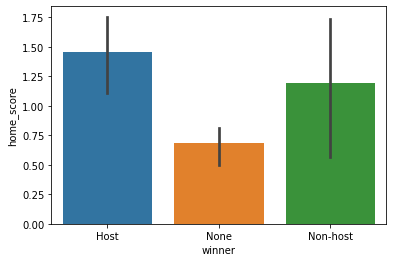

In [63]:
sns.barplot(x='winner',y='home_score',data=acr_df_worldcup_host,estimator=np.std)

In [ ]:
def plot_history(history, kind='acc'):
    plt.figure()
    plt.xlabel('Iteration Round')
    if kind == 'acc':
        plt.ylabel('Accuracy')
        plt.plot(history.epoch, np.array(history.history['acc']),
                 label='Training Set')
        plt.plot(history.epoch, np.array(history.history['val_acc']),
                 label = 'Validation Set')
        plt.legend()
    elif kind == 'Loss':
        plt.ylabel('Logarithmic Loss')
        plt.plot(history.epoch, np.array(history.history['loss']),
                 label='Training Set')
        plt.plot(history.epoch, np.array(history.history['val_loss']),
                 label = 'Validation Set')
        plt.legend()
        
    plt.show()


In [6]:
# 导入包含比赛数据统计信息的比赛数据
match_df = pd.read_csv('data/match.csv')
match_df.describe()

,id,country_id,league_id,stage,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,...,home_team_cross,home_team_corner,home_team_possession,away_team_shoton,away_team_shotoff,away_team_foulcommit,away_team_card,away_team_cross,away_team_corner,away_team_possession
count,25979.000000,25979.000000,25979.000000,25979.000000,2.597900e+04,25979.000000,25979.000000,25979.000000,25979.000000,24158.000000,...,8465.000000,8464.000000,8419.000000,8463.000000,8463.000000,8465.000000,13773.000000,8465.000000,8464.000000,8419.000000
mean,12990.000000,11738.630317,11738.630317,18.242773,1.195429e+06,9984.371993,9984.475115,1.544594,1.160938,0.999586,...,18.870053,5.843809,51.796042,4.897436,4.994683,13.203544,2.433747,14.750030,4.523866,48.203958
std,7499.635658,7553.936759,7553.936759,10.407354,4.946279e+05,14087.453758,14087.445135,1.297158,1.142110,0.022284,...,8.195069,3.002254,9.401134,2.791269,2.619508,4.445138,1.463537,7.047327,2.594069,9.401134
min,1.000000,1.000000,1.000000,1.000000,4.831290e+05,1601.000000,1601.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,19.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.875000
25%,6495.500000,4769.000000,4769.000000,9.000000,7.684365e+05,8475.000000,8475.000000,1.000000,0.000000,1.000000,...,13.000000,4.000000,45.750000,3.000000,3.000000,10.000000,1.000000,10.000000,3.000000,42.000000
50%,12990.000000,10257.000000,10257.000000,18.000000,1.147511e+06,8697.000000,8697.000000,1.000000,1.000000,1.000000,...,18.000000,5.000000,52.000000,5.000000,5.000000,13.000000,2.000000,14.000000,4.000000,48.000000
75%,19484.500000,17642.000000,17642.000000,27.000000,1.709852e+06,9925.000000,9925.000000,2.000000,2.000000,1.000000,...,24.000000,8.000000,58.000000,7.000000,7.000000,16.000000,3.000000,19.000000,6.000000,54.250000
max,25979.000000,24558.000000,24558.000000,38.000000,2.216672e+06,274581.000000,274581.000000,10.000000,9.000000,2.000000,...,72.000000,20.000000,81.125000,19.000000,19.000000,32.000000,12.000000,59.000000,19.000000,80.500000


In [34]:
# 合成净胜球数
goal_diff = match_df['home_team_goal'] - match_df['away_team_goal']

# 对比赛结果进行编码
# 主队获胜：0
# 双方打平：1
# 客队获胜：2
y = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

print('预测准确率\n')
# 随机猜测
np.random.seed(42)
y_pred = np.random.choice([0,1,2], len(y))
print('随机猜测：  {:.1f}%'.format(accuracy_score(y, y_pred)*100))

# 只猜主队赢
y_pred = np.zeros(len(y))
print('只猜主队赢：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

# 只猜平局
y_pred = np.ones(len(y))
print('只猜平局：  {:.1f}%'.format(accuracy_score(y, y_pred)*100))

# 只猜客队赢
y_pred = 2*np.ones(len(y))
print('只猜客队赢：{:.1f}%'.format(accuracy_score(y, y_pred)*100))

预测准确率

随机猜测：  33.5%
只猜主队赢：45.9%
只猜平局：  25.4%
只猜客队赢：28.7%


In [9]:
# 射门相关的数据包括：射正（非进球）数、射偏数和进球数
shot_events = ['shoton', 'shotoff', 'goal']

# 选择主客队射门相关的信息
home_team_feature = ['home_team_{}'.format(i) for i in shot_events]
away_team_feature = ['away_team_{}'.format(i) for i in shot_events]

# 移除缺失数据
for col in home_team_feature + away_team_feature:
    match_df = match_df[match_df[col].notnull()]

# 合成射门数
match_df['home_team_shot'] = match_df['home_team_shoton'] + match_df['home_team_shotoff'] + match_df['home_team_goal']
match_df['away_team_shot'] = match_df['away_team_shoton'] + match_df['away_team_shotoff'] + match_df['away_team_goal']

# 合成净胜球数
goal_diff = match_df['home_team_goal'] - match_df['away_team_goal']

# 对比赛结果进行编码
# 主队获胜：0
# 双方打平：1
# 客队获胜：2
match_df['result'] = np.where(goal_diff > 0, 0, np.where(goal_diff < 0, 2, 1))

# 选择比赛相关信息
events = ['foulcommit', 'card', 'cross', 'corner', 'possession', 'shot']
event_features = ['home_team_{}'.format(i) for i in events] + ['away_team_{}'.format(i) for i in events]

# 确认使用的信息
feature_list = event_features

# 生成建模数据
# 移除缺失值
match_sel = match_df
for col in feature_list:
    match_sel = match_sel[match_sel[col].notnull()]
    
# 训练集/测试集划分
train_df, test_df = train_test_split(match_sel, test_size=1000, random_state=42)

Xtrain = train_df[feature_list].values
Xtest = test_df[feature_list].values

y = match_sel['result'].values
ytrain = train_df['result'].values
ytest = test_df['result'].values

hgoaltrain = train_df['home_team_goal'].values
hgoaltest = test_df['home_team_goal'].values

agoaltrain = train_df['away_team_goal'].values
agoaltest = test_df['away_team_goal'].values

gdtrain = hgoaltrain-agoaltrain
gdtest = hgoaltest-agoaltest

# 输入数据正则化
mms = MinMaxScaler()

Xtrain_norm = mms.fit_transform(Xtrain)
Xtest_norm = mms.transform(Xtest)

print('总数据量：                    {}'.format(match_sel.shape[0]))
print('训练数据量（包括交叉验证数据）：{}'.format(train_df.shape[0]))
print('测试数据量：                  {}'.format(test_df.shape[0]))

总数据量：                    8124
训练数据量（包括交叉验证数据）：7124
测试数据量：                  1000


最优的C为：100000.0
对数损失值（训练数据）：  0.9327
对数损失值(交叉验证数据)：0.9363


/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36923 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36753 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24402 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36229 missing f

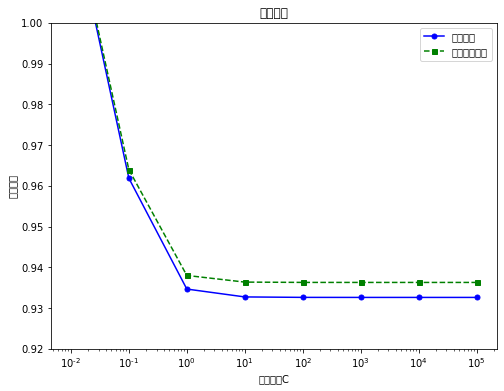

In [10]:
# 逻辑回归
clf = LogisticRegression(multi_class='auto', solver='liblinear')
parameter_dic= {'C':[0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]}

# 使用交叉验证和对数损失来确定超参数
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain_norm,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

clf_dict = {'LogisticRegression': '逻辑回归',
            'GradientBoostingClassifier': '梯度提升',
            'RandomForestClassifier': '随机森林'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='训练数据')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='交叉验证数据')
plt.xlabel('超参数：{}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(0.92, 1)

print('最优的{}为：{}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('对数损失值（训练数据）：  {:.4f}'.format(-1*train_mean[np.argmax(test_mean)]))
print('对数损失值(交叉验证数据)：{:.4f}'.format(-1*np.max(test_mean)))

In [11]:
best_clf = LogisticRegression(C=100000, multi_class='auto', solver='liblinear')

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('逻辑回归模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

逻辑回归模型评估
对数损失：0.9240
预测准确率：56.6%


In [12]:
best_clf = LinearDiscriminantAnalysis()

best_clf.fit(Xtrain_norm, ytrain)
ytest_prob = best_clf.predict_proba(Xtest_norm)

#### 模型评估
print('线性判别分析模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

线性判别分析模型评估
对数损失：0.9195
预测准确率：56.6%


In [26]:
class PoissonRegression:
    
    def __init__(self):
        pass
    
    def fit(self, X_home, X_away, hgoal, agoal):
        """
        Fit poisson regression model.
        
        Parameters
        ----------
        X_home:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for home team.
        X_away:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for away team.
        hgoal:
            1d array-like, shape (n_samples, ). Array of goals for home team.
        agoal:
            1d array-like, shape (n_samples, ). Array of goals for away team.      
        """
        
        self.hgoal_reg = sm.GLM(hgoal, X_home, family=sm.families.Poisson()).fit()
        self.agoal_reg = sm.GLM(agoal, X_away, family=sm.families.Poisson()).fit()
        
    def _lambda(self, X_home, X_away):
        """
        Estimated goals for home team and away team.
        
        Parameters
        ----------
        X_home:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for home team.
        X_away:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for away team.
        
        Returns
        -------
        hgoal_lambda:
            1d array-like, shape (n_samples, ). Array of estimated goals for home team.
        agoal_lambda:
            1d array-like, shape (n_samples, ). Array of estimated goals for away team.
        """
        
        hgoal_lambda = self.hgoal_reg.predict(X_home)
        agoal_lambda = self.agoal_reg.predict(X_away)
        
        return hgoal_lambda, agoal_lambda

    def predict_proba(self, X_home, X_away, n_max=20):
        """
        Predict match outcome probabilities.
        Parameters
        ----------
        X_home:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for home team.
        X_away:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for away team.
        n_max: 
            int, no less than 0. Maxmium goals for a team per match.
            
        Returns
        -------
        p_matrix:
            2d array-like, shape (n_samples, 3). Matrix of estimated probabilities. Each row is the probabilities for 3 possibile outcomes of each match.
        """
        
        hgoal_lambda, agoal_lambda = self._lambda(X_home, X_away)

        p_win = np.sum(skellam.pmf(np.arange(n_max)+1, hgoal_lambda.reshape(-1,1), agoal_lambda.reshape(-1,1)), axis=1)
        p_draw = np.sum(skellam.pmf(0, hgoal_lambda.reshape(-1,1), agoal_lambda.reshape(-1,1)), axis=1)
        p_lose = np.sum(skellam.pmf(np.arange(n_max)-n_max, hgoal_lambda.reshape(-1,1), agoal_lambda.reshape(-1,1)), axis=1)
    
        p_matrix = np.array([p_win,p_draw, p_lose]).transpose()
        
        return p_matrix
    
    def predict(self, X_home, X_away, n_max=20):
        """
        Predict match outcomes.
        
        Parameters
        ----------
        X_home:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for home team.
        X_away:
            2d array-like, shape (n_samples, n_features). Input information to predict estimated goals for away team.
        n_max: 
            int, no less than 0. Maxmium goals for a team per match.
            
        Returns
        -------
        ypred:
            1d array-like, shape (n_samples, ). Array of encoded match outcomes.
        """

        ypred = self.predict_proba(X_home, X_away, n_max=n_max).argmax(axis=1)
        
        return ypred

In [27]:
best_clf = PoissonRegression()

best_clf.fit(Xtrain_norm, Xtrain_norm, hgoaltrain, agoaltrain)
ytest_prob = best_clf.predict_proba(Xtest_norm, Xtest_norm)

#### 模型评估
print('泊松回归模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

泊松回归模型评估
对数损失：0.9329
预测准确率：56.0%


/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 27850 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26494 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24402 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65306 missing f

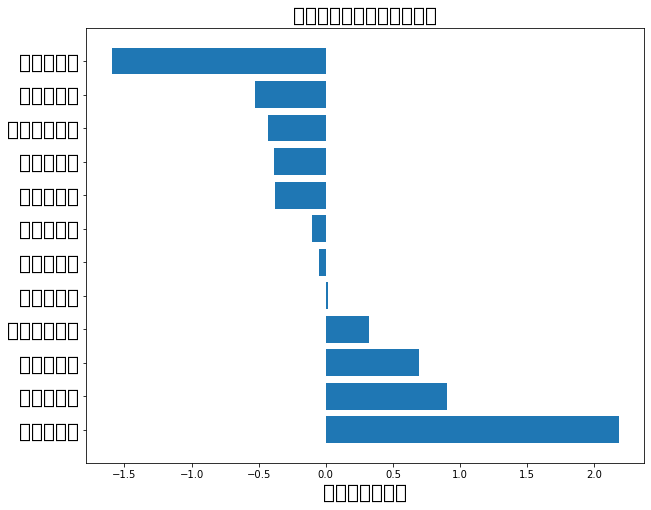

In [28]:
feature_dic = {'home_team_foulcommit': '主队犯规数',
               'home_team_card': '主队红黄牌数',
               'home_team_cross': '主队传中数',
               'home_team_corner': '主队角球数',
               'home_team_possession': '主队控球率',
               'home_team_shot': '主队射门数',
               'away_team_foulcommit': '客队犯规数',
               'away_team_card': '客队红黄牌数',
               'away_team_cross': '客队传中数',
               'away_team_corner': '客队角球数',
               'away_team_possession': '客队控球率',
               'away_team_shot': '客队射门数'}

# 显示中文特征值
feature_list_cn = [feature_dic[key] for key in feature_list]

encoded_home_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.hgoal_reg.params, encoded_home_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测主队进球数', fontsize=20)
plt.show()

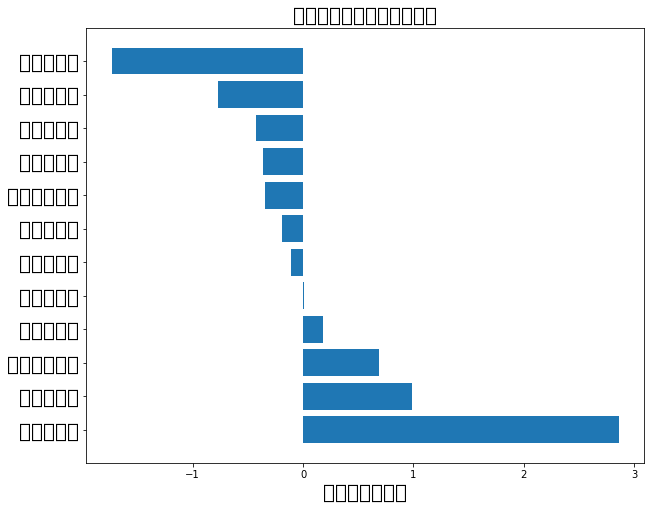

In [29]:
encoded_away_feature_list = feature_list_cn
importance_list, name_list = zip(*sorted(zip(best_clf.agoal_reg.params, encoded_away_feature_list),reverse=True))

plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)), importance_list,align='center')
plt.yticks(range(len(name_list)), name_list, fontsize=20)
plt.xlabel('泊松回归系数值', fontsize=20)
plt.title('泊松回归：预测客队进球数', fontsize=20)
plt.show()

In [30]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.07
param_reg['subsample'] = 0.4
param_reg['colsample_bytree'] = 0.9
param_reg['max_depth'] = 2
param_reg['num_parallel_tree'] = 4
param_reg['min_child_weight'] = 5

parameter_dic = {'eta':np.arange(0.01, 0.1, 0.01)}
param_tune = list(parameter_dic.keys())[0]
param_len = len(parameter_dic[param_tune])

cross_validation_fold = 10

xgb_cv = []
kf = KFold(n_splits=cross_validation_fold, shuffle=True, random_state=42)

train_mean = []
val_mean = []

reg_progress = {}
clf_progress = {}

reg_num_boost_round_mean = []
clf_num_boost_round_mean = []

for i in range(param_len):
    param_reg[param_tune] = parameter_dic[param_tune][i]
    
    train_scores = []
    val_scores = []
    
    reg_num_boost_round = []
    clf_num_boost_round = []
    
    for train, val in kf.split(Xtrain, gdtrain):
        dtrain = xgb.DMatrix(Xtrain[train], label = gdtrain[train])
        dval = xgb.DMatrix(Xtrain[val], label = gdtrain[val])
        reg = xgb.train(params=param_reg, dtrain=dtrain,
                        num_boost_round=3000,
                        early_stopping_rounds=25, evals=[(dval,'validation')],
                        evals_result=reg_progress,
                        verbose_eval=False)
        reg_num_boost_round.append(len(reg_progress['validation']['rmse']))
        Ztrain = reg.predict(dtrain).reshape(-1, 1)
        Zval = reg.predict(dval).reshape(-1, 1)
        ltrain = xgb.DMatrix(Ztrain, label=ytrain[train])
        lval = xgb.DMatrix(Zval, label = ytrain[val])
        
        clf = LogisticRegression(solver='liblinear', C=10000) # minimizing regularization by setting C to a very large number
        clf.fit(Ztrain, ytrain[train])
        train_scores.append(log_loss(ytrain[train], clf.predict_proba(Ztrain)))
        val_scores.append(log_loss(ytrain[val], clf.predict_proba(Zval)))

    train_mean.append(np.mean(np.array(train_scores)))
    val_mean.append(np.mean(np.array(val_scores)))
    
    reg_num_boost_round_mean.append(np.mean(np.array(reg_num_boost_round)))

print(reg_num_boost_round_mean)

[17:16:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:51] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:16:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:16:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-sp

[17:18:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:18:30] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:18:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:18:34] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-sp

[17:19:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-sp

[17:19:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:19:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:19:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-sp

[17:20:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:19] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:20:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:20] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-sp

[17:20:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:39] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:20:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:40] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-sp

[17:20:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:56] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:20:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:20:57] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-sp

最优的eta为：0.08
对数损失值（交叉验证数据）：0.9436


/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36229 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 21442 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 23545 missing f

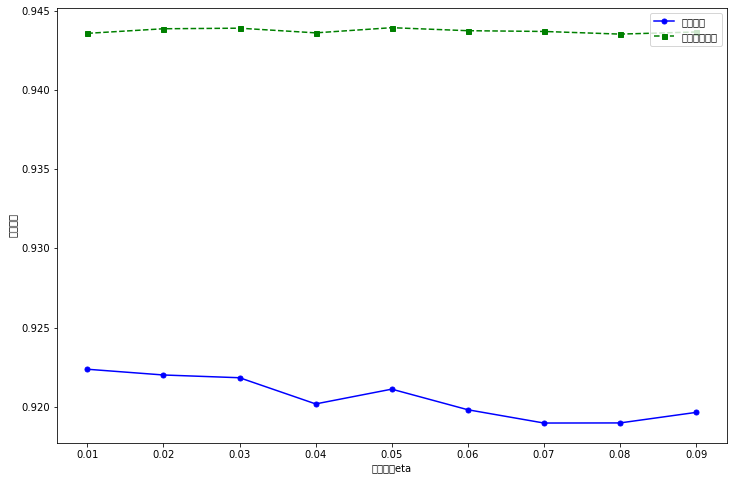

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(parameter_dic[param_tune], np.array(train_mean),
         color='blue', marker='o', markersize=5, label='训练数据')
plt.plot(parameter_dic[param_tune], np.array(val_mean),
         color='green', linestyle='--', marker='s', markersize=5, label='交叉验证数据')
plt.xlabel('超参数：{}'.format(param_tune))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
print('最优的{}为：{}'.format(param_tune, parameter_dic[param_tune][np.argmin(val_mean)]))
print('对数损失值（交叉验证数据）：{:.4f}'.format(np.min(val_mean)))

In [18]:
param_reg = {} 
param_reg['objective'] = 'reg:linear'
param_reg['eval_metric'] =  'rmse'
param_reg['booster'] = 'gbtree'
param_reg['silent'] = 1

param_reg['eta'] = 0.07
param_reg['subsample'] = 0.4
param_reg['colsample_bytree'] = 0.9
param_reg['max_depth'] = 2
param_reg['num_parallel_tree'] = 4
param_reg['min_child_weight'] = 5

dtrain = xgb.DMatrix(Xtrain, label = gdtrain)
reg = xgb.train(params=param_reg, dtrain=dtrain,
                num_boost_round=int(263),
                verbose_eval=False)
        
Ztrain = reg.predict(dtrain).reshape(-1, 1)
clf = LogisticRegression(solver='liblinear', C=10000)
clf.fit(Ztrain, ytrain)

dtest = xgb.DMatrix(Xtest, label = gdtest)
Ztest = reg.predict(dtest).reshape(-1,1)
ytest_prob = clf.predict_proba(Ztest)

print('XGBoost模型评估')
print('对数损失：{:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

[17:12:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:01] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost模型评估
对数损失：0.9274
预测准确率：56.7%


最优的n_estimators为：180
对数损失值（训练数据）：  0.2416
对数损失值(交叉验证数据)：0.9577


/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 38543 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26426 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26862 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26519 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36229 missing f

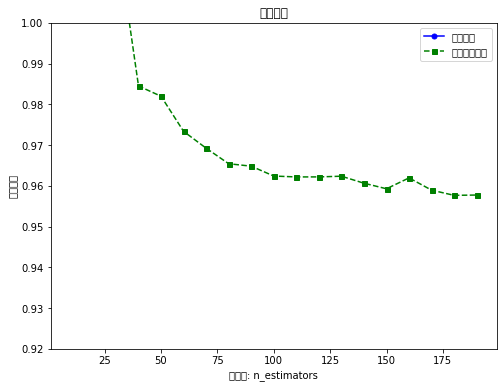

In [19]:
clf = RandomForestClassifier(max_features=3, n_estimators=160)
parameter_dic= {'n_estimators':range(10, 200, 10)}

# 使用交叉验证和对数损失来确定超参数
cross_validation_fold = 5

train_scores, test_scores=validation_curve(estimator=clf,
                                           X=Xtrain,
                                           y=ytrain,
                                           param_name=list(parameter_dic.keys())[0],
                                           param_range=parameter_dic.get(list(parameter_dic.keys())[0]),
                                           cv=cross_validation_fold, scoring='neg_log_loss')
train_mean=np.mean(train_scores, axis=1)
train_std=np.std(train_scores,axis=1)
test_mean=np.mean(test_scores, axis=1)
test_std=np.std(test_scores,axis=1)

clf_dict = {'LogisticRegression': '逻辑回归',
            'GradientBoostingClassifier': '梯度提升',
            'RandomForestClassifier': '随机森林'
           }
plt.figure(figsize=(8,6))
plt.rcParams['mathtext.fontset'] = 'cm' # 数学负号使用机器默认字体
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*train_mean,
         color='blue',marker='o',
         markersize=5,label='训练数据')
plt.plot(parameter_dic.get(list(parameter_dic.keys())[0]),-1*test_mean,
         color='green',linestyle='--',
         marker='s',markersize=5,label='交叉验证数据')
plt.xlabel('超参数: {}'.format(list(parameter_dic.keys())[0]))
plt.ylabel('对数损失')
plt.legend(loc='upper right')
plt.title('{}'.format(clf_dict[clf.__class__.__name__]))
if clf.__class__.__name__ == 'LogisticRegression':
    plt.xscale('log')
plt.ylim(0.92, 1)

print('最优的{}为：{}'.format(list(parameter_dic.keys())[0], parameter_dic.get(list(parameter_dic.keys())[0])[np.argmax(test_mean)]))
print('对数损失值（训练数据）：  {:.4f}'.format(-1*train_mean[np.argmax(test_mean)]))
print('对数损失值(交叉验证数据)：{:.4f}'.format(-1*np.max(test_mean)))

In [20]:
best_clf = RandomForestClassifier(max_features=3, n_estimators=170)

np.random.seed(42)
best_clf.fit(Xtrain, ytrain)
ytest_prob = best_clf.predict_proba(Xtest)

#### 模型评估
print('随机森林模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))

随机森林模型评估
对数损失：  0.9458
预测准确率：56.4%


/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 38543 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26426 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26862 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26519 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/laiweifeng/opt/anaconda3/envs/info6105final/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30456 missing f

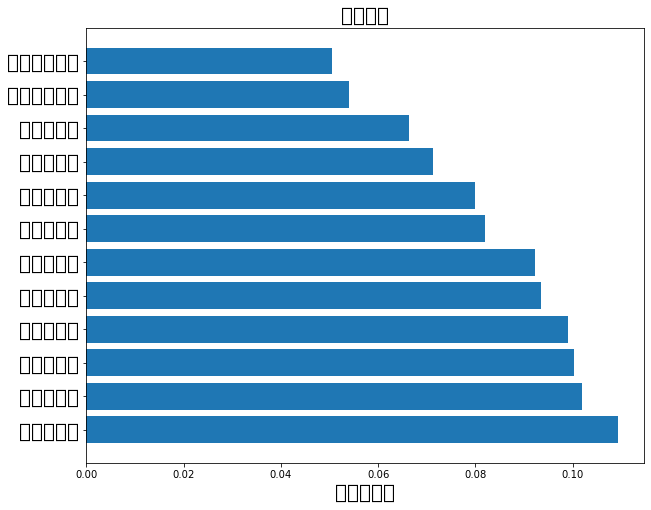

In [21]:
importance_list = best_clf.feature_importances_
importance_list, name_list = zip(*sorted(zip(importance_list, feature_list_cn),reverse=True))
plt.figure(figsize=(10,8))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list, fontsize=20)
plt.xlabel('相对重要性', fontsize=20)
plt.title('随机森林', fontsize=20)
plt.show()


In [22]:
# 训练集/验证集划分
train_x, val_x, train_y, val_y = train_test_split(Xtrain_norm, ytrain, test_size=1000, stratify=ytrain, random_state=42)

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                          input_shape=(Xtrain_norm.shape[1],), ),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.7),
        keras.layers.Dense(3, activation=tf.nn.softmax)
    ])
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.train.AdamOptimizer(),
                  metrics=['accuracy'])
    
    return model

model = build_model()

AttributeError: module 'tensorflow_core._api.v2.train' has no attribute 'AdamOptimizer'

In [ ]:
# The patience parameter is the amount of epochs to check for improvement
#early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(train_x, train_y, epochs=500,
                    validation_data=(val_x, val_y), verbose=0)

print('当前模型训练集的准确率为{:.2f}%'.format(history.history['acc'][-1]*100))
print('当前模型训练集的对数损失为{:.3f}'.format(history.history['loss'][-1]))

print('当前模型验证集的准确率{:.2f}%'.format(history.history['val_acc'][-1]*100))
print('当前模型验证集的对数损失为{:.3f}'.format(history.history['val_loss'][-1]))

plot_history(history, kind='loss')
plt.ylim(0.9, 1);

In [ ]:
# 拟合训练数据
model.fit(Xtrain_norm, ytrain, epochs=500, verbose=0)

# 输出比赛结果概率估计
ytest_prob = model.predict_proba(Xtest_norm)

#### 模型评估
print('神经网络模型评估')
print('对数损失：  {:.4f}'.format(log_loss(ytest, ytest_prob)))
print('预测准确率：{:.1f}%'.format(accuracy_score(ytest, np.argmax(ytest_prob, axis=1))*100))